# Libs

In [1]:
import os
#tensor flow for modeling with tf 
import tensorflow as tf 

#pytorch ato use another way 
import torch
import torchvision.models as models
from torchsummary import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


#pandas and numpay i will use it in way num3 (genral arcticture)
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
import copy

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt 
import plotly.express as px 
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import warnings
warnings.simplefilter('ignore')

# Deep learning Algorithem

## 1.TensorFlow

### 1.1 Load data 

In [2]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 , zoom_range=0.2,validation_split=0.2,horizontal_flip=True
)

#### 1.1.1 Training Data

In [3]:
%%time
#I prefer to collecting data this way. There are many ways to collect this.
#Create full DataFrame
train_data =img_gen.flow_from_directory(
    subset="training",directory='Fruit And Vegetable Diseases Dataset',target_size=(224,224),class_mode='binary',batch_size=32)

Found 23431 images belonging to 28 classes.
CPU times: total: 156 ms
Wall time: 713 ms


#### 1.1.2 Test Data

In [4]:
%%time
test_data = img_gen.flow_from_directory(
    subset="validation",directory='Fruit And Vegetable Diseases Dataset',target_size=(224,224),class_mode='binary',batch_size=32)

Found 5846 images belonging to 28 classes.
CPU times: total: 62.5 ms
Wall time: 331 ms


#### 1.1.3 Visualizing data distribution

In [5]:
train_df = pd.DataFrame(train_data.classes, columns=['classes'])
test_df = pd.DataFrame(test_data.classes, columns=['classes'])

In [6]:
classes_names = {}
for key in train_data.class_indices:
    classes_names[train_data.class_indices[key]] = key

##### 1.1.3.1 Training Data

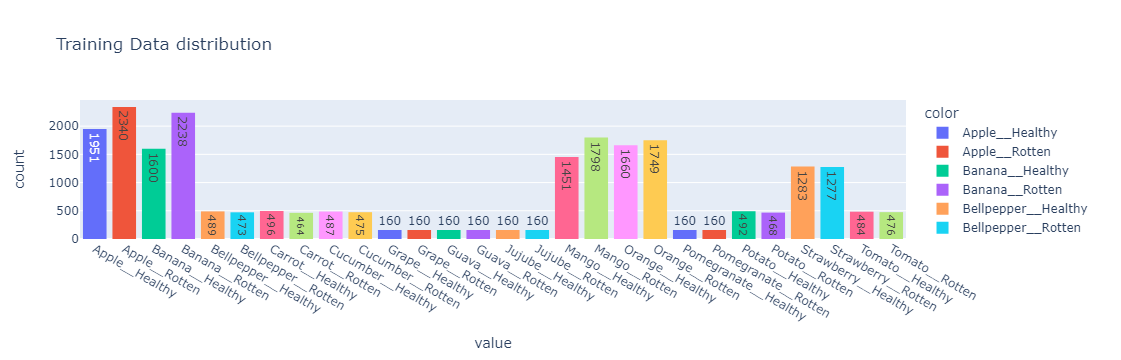

In [7]:
px.histogram(train_df['classes'].map(classes_names) , title='Training Data distribution' ,
             color = train_df['classes'].map(classes_names),
            text_auto=True)

##### 1.1.3.2 Testing Data

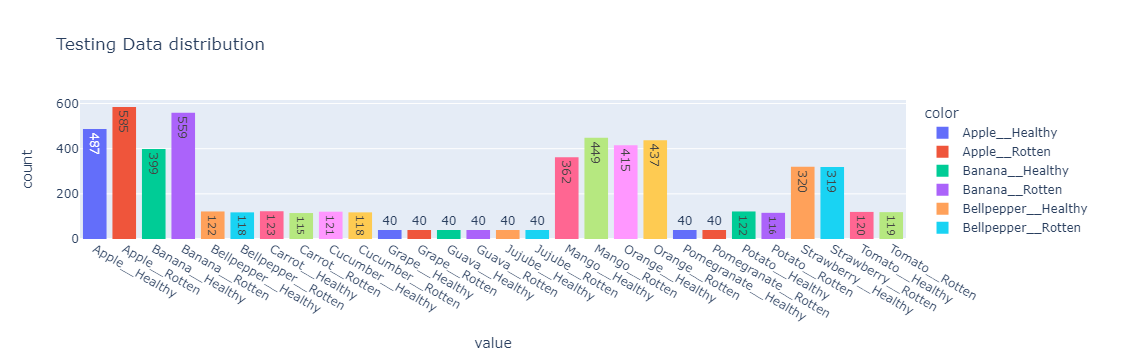

In [8]:
px.histogram(test_df['classes'].map(classes_names) , title='Testing Data distribution' ,
             color = test_df['classes'].map(classes_names),
            text_auto=True)

### 1.2 VGG16

#### 1.2.1 Prepairing Model

In [9]:
vgg16 =  tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

In [10]:
vgg16.trainable = False

#### 1.2.2 Add a custom layers

In [11]:
x = vgg16.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
prediction = tf.keras.layers.Dense(28, activation='softmax')(x)

In [12]:
model = tf.keras.Model(inputs=vgg16.input ,outputs=prediction)

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      25,691,136 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 40,675,420 (155.16 MB)

 Trainable params: 25,960,732 (99.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### 1.2.3 Train model

In [15]:
%%time
batch_size= 32
r = model.fit(
 train_data, epochs = 10
)

Epoch 1/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2024s 3s/step - accuracy: 0.5773 - loss: 1.8494
Epoch 2/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 1959s 3s/step - accuracy: 0.8510 - loss: 0.4584
Epoch 3/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 1967s 3s/step - accuracy: 0.8911 - loss: 0.3391
Epoch 4/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 1953s 3s/step - accuracy: 0.9093 - loss: 0.2762
Epoch 5/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2002s 3s/step - accuracy: 0.9198 - loss: 0.2367
Epoch 6/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2001s 3s/step - accuracy: 0.9321 - loss: 0.2075
Epoch 7/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2041s 3s/step - accuracy: 0.9413 - loss: 0.1777
Epoch 8/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 2065s 3s/step - accuracy: 0.9491 - loss: 0.1564
Epoch 9/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 1965s 3s/step - accuracy: 0.9426 - loss: 0.1728
Epoch 10/10
733/733 ━━━━━━━━━━━━━━━━━━━━ 1958s 3s/step - accuracy: 0.9547 - loss: 0.1400
CPU times: total: 2d 4h 34min 7s
Wall time: 5h 32min 16s


#### 1.2.4 Evaluation model

In [16]:
%%time
model.evaluate(test_data)

183/183 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.8884 - loss: 0.5445
CPU times: total: 1h 18min 16s
Wall time: 8min 17s


[0.5637587904930115, 0.8816284537315369]

In [17]:
model.save('28_VGG16_88.keras')

## 2.PyTorch 

### 2.1 Load Data

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4, 0.4, 0.4],[0.3,0.3,0.3])
])

In [19]:
full_dataset = datasets.ImageFolder(root="Fruit And Vegetable Diseases Dataset" , transform=transform)

In [20]:
train_size = int(0.75*len(full_dataset))
test_size = len(full_dataset) - train_size
print(
    f"""Train Size : {train_size} = 75% of full dataset size({len(full_dataset)})
Test Size : {test_size} = 25% of full dataset size({len(full_dataset)})
Train size + Test size = {train_size+test_size}"""
)

Train Size : 21968 = 75% of full dataset size(29291)
Test Size : 7323 = 25% of full dataset size(29291)
Train size + Test size = 29291


In [21]:
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

#### 2.1.1 Training Data

In [22]:
train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size= 64, 
                num_workers = 0,
                shuffle = True)

#### 2.1.2 Testing data

In [23]:
test_loader = torch.utils.data.DataLoader(
                test_dataset,
                batch_size= 64, 
                num_workers = 0,
                shuffle = True)

### 2.2 EfficientNet

#### 2.2.1 Prepairing Model 

In [24]:
model_th = models.efficientnet_b0(pretrained=True)

#### 2.2.2 Set model prametars

In [25]:
model_th.classifier[1]

Linear(in_features=1280, out_features=1000, bias=True)

In [26]:
#replace the final classifier layer with a new one for 28 classes
in_features = model_th.classifier[1].in_features
model_th.classifier[1] = torch.nn.Linear(in_features,28)

In [27]:
model_th.classifier[1]

Linear(in_features=1280, out_features=28, bias=True)

In [28]:
loss= torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_th.parameters(), lr=0.001)

#### 2.2.3 Train and Test model

In [29]:
def train(model,train_loader, optimizer, epoch,loss_fn):
    total_batches = len(train_loader)
    with tqdm(total=total_batches, unit="batch", desc=f"""Train:Epoch {epoch}""") as pbar:
        model.train()
        train_loss = 0
        correct = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            
            optimizer.zero_grad()
            
            output = model(data)
            
            
            loss = loss_fn(output, target)
            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)

            correct += torch.sum(target==predicted).item()
            
            loss.backward()
            
            optimizer.step()
            
            pbar.update(1)
    
    avg_loss = train_loss / (batch_idx+1) 
    print('Training set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avg_loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
    return {'loss':avg_loss,'accuracy':100. *( correct / len(train_loader.dataset))}

In [33]:
def test(model,test_loader,epoch,loss_fn):
    total_batches = len(test_loader)
    with tqdm(total=total_batches, unit="batch", desc=f"""Test:Epoch {epoch}""") as pbar:
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for batch_idx ,(data, target) in enumerate(test_loader):
        
                output = model(data)
                
                test_loss += loss_fn(output, target).item()
                
                _, predicted = torch.max(output.data, 1)
                
                correct += torch.sum(target==predicted).item()
                pbar.update(1)
        avg_loss = test_loss/(batch_idx+1)
        print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            avg_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return {'loss':avg_loss,'accuracy':100. *( correct / len(test_loader.dataset))} 

In [34]:
%%time
loss_data = {}
epochs = 3
for epoch in range(1,epochs+1):
    loss_data['Training'] = {}
    loss_data['Testing'] = {}
    loss_data['Training'][epoch] = train(model_th , train_loader , optimizer ,epoch,loss)
    loss_data['Testing'][epoch] = test(model_th , test_loader , epoch , loss)

Train:Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [51:29<00:00,  8.98s/batch]


Training set: Average loss: 0.063163, Accuracy: 21548/21968 (98%)



Test:Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [04:57<00:00,  2.58s/batch]


Validation set: Average loss: 0.093862, Accuracy: 7135/7323 (97%)



Train:Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [47:44<00:00,  8.33s/batch]


Training set: Average loss: 0.057171, Accuracy: 21570/21968 (98%)



Test:Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [04:53<00:00,  2.55s/batch]


Validation set: Average loss: 0.062382, Accuracy: 7192/7323 (98%)



Train:Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 344/344 [47:36<00:00,  8.31s/batch]


Training set: Average loss: 0.048985, Accuracy: 21613/21968 (98%)



Test:Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [04:53<00:00,  2.55s/batch]

Validation set: Average loss: 0.117578, Accuracy: 7109/7323 (97%)

CPU times: total: 14h 20min 33s
Wall time: 2h 41min 35s


In [36]:
torch.save(model_th.state_dict(),'28_EfficientNet_97.pth')

##  3.General Architecture of the learning algorithm

### 3.1 Load data

#### 3.1.1 Full DataFrame

In [37]:
%%time 
#Creat dataframe
df = pd.DataFrame(columns = ['image','class'])
row_num =0
for class_ in os.listdir(path='Fruit And Vegetable Diseases Dataset/'):
    for image in os.listdir(path=f"Fruit And Vegetable Diseases Dataset/{class_}")[:200]:
        try:
            image = Image.open(f'Fruit And Vegetable Diseases Dataset/{class_}/{image}').convert('RGB')
            resized_img = image.resize((224,224))
            resized_img_array = np.array(resized_img)/255.0
            df.at[row_num,'image'] = resized_img_array
            df.at[row_num,'class'] = class_
            row_num +=1
        except:
            continue

CPU times: total: 2min 50s
Wall time: 2min 52s


#### 3.1.2 X,Y

In [38]:
x , y = np.array([i for i in [i for i in df['image']]]) , df['class'].map(train_data.class_indices)

In [39]:
x.shape , y.shape

((5600, 224, 224, 3), (5600,))

#### 3.1.3 Train test split 

In [40]:
x_train , x_test, y_train , y_test = train_test_split(x,y,test_size=0.25)

#### 3.1.4 Flatten 

In [41]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1).T
x_test_flattened = x_test.reshape(x_test.shape[0], -1).T

In [42]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels].T

num_classes = 28
y_train_encoded = one_hot_encode(y_train, num_classes)
y_test_encoded = one_hot_encode(y_test, num_classes)

### 3.2 Build model 

#### 3.2.1 set Activation Function

In [43]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

#### 3.2.2 Initializing the weights

In [44]:
def initialize_with_zeros(dim, num_classes):
    w = np.zeros((dim, num_classes))
    b = np.zeros((num_classes, 1))
    return w, b

#### 3.2.3 Forward Propagation func

In [45]:
def propagate(w, b, X, Y):
    m = X.shape[1]
    A = softmax(np.dot(w.T, X) + b)
    cost = np.mean((A - Y) ** 2)  # MSE loss

    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y, axis=1, keepdims=True)  # Adjusted shape of db

    cost = np.squeeze(cost)
    grads = {"dw": dw, "db": db}

    return grads, cost

#### 3.2.4 Optimaizing loss function 

In [46]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    costs = []

    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration %i: %f" % (i, cost))

    params = {"w": w, "b": b}
    grads = {"dw": dw, "db": db}

    return params, grads, costs

#### 3.2.5 Predict func 

In [47]:
def predict(w, b, X):
    A = softmax(np.dot(w.T, X) + b)
    Y_prediction = np.argmax(A, axis=0)
    return Y_prediction

In [48]:
def calculate_accuracy(predictions, labels):
    correct_predictions = np.sum(predictions == labels)
    accuracy = correct_predictions / labels.shape[0] * 100
    return accuracy

#### 3.2.6 Make Model

In [49]:
def model_nn(X_train, Y_train, X_test, Y_test, learning_rate=0.005, target_accuracy=90, max_iterations=2000, print_cost=False):
    num_features = X_train.shape[0]
    num_classes = Y_train.shape[0]
    
    w, b = initialize_with_zeros(num_features, num_classes)
    costs = []
    iteration = 0

    while iteration < max_iterations:
        grads, cost = propagate(w, b, X_train, Y_train)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if iteration % 100 == 0:
            costs.append(cost)
            train_predictions = predict(w, b, X_train)
            train_accuracy = calculate_accuracy(train_predictions, np.argmax(Y_train, axis=0))
            test_predictions = predict(w, b, X_test)
            test_accuracy = calculate_accuracy(test_predictions, np.argmax(Y_test, axis=0))
            
            if print_cost:
                print(f"Cost after iteration {iteration}: {cost:.6f}")
            
            if (train_accuracy) >= target_accuracy and (test_accuracy>target_accuracy-5):
                print(f"Target accuracy of {target_accuracy}% reached at iteration {iteration}")
                break
        
        iteration += 1
    
    train_predictions = predict(w, b, X_train)
    test_predictions = predict(w, b, X_test)
    
    train_accuracy = calculate_accuracy(train_predictions, np.argmax(Y_train, axis=0))
    test_accuracy = calculate_accuracy(test_predictions, np.argmax(Y_test, axis=0))
    
    if print_cost:
        print(f"Final train accuracy: {train_accuracy:.2f}%")
        print(f"Final test accuracy: {test_accuracy:.2f}%")
    
    d = {
        "costs": costs,
        "Y_prediction_test": test_predictions,
        "Y_prediction_train": train_predictions,
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": iteration
    }
    
    return d

#### 3.2.7 Train and test model 

In [50]:
%%time
logistic_regression_model = model_nn(X_train=x_train_flattened, 
                                  Y_train=y_train_encoded,
                                  X_test= x_test_flattened,
                                  Y_test= y_test_encoded,
                                  target_accuracy=90,
                                  max_iterations=25000,
                                  learning_rate=0.0008,
                                  print_cost=True)

Cost after iteration 0: 0.034439
Cost after iteration 100: 0.024989
Cost after iteration 200: 0.022175
Cost after iteration 300: 0.020617
Cost after iteration 400: 0.019535
Cost after iteration 500: 0.018693
Cost after iteration 600: 0.017999
Cost after iteration 700: 0.017404
Cost after iteration 800: 0.016880
Cost after iteration 900: 0.016411
Cost after iteration 1000: 0.015985
Cost after iteration 1100: 0.015593
Cost after iteration 1200: 0.015230
Cost after iteration 1300: 0.014892
Cost after iteration 1400: 0.014574
Cost after iteration 1500: 0.014274
Cost after iteration 1600: 0.013991
Cost after iteration 1700: 0.013721
Cost after iteration 1800: 0.013464
Cost after iteration 1900: 0.013218
Cost after iteration 2000: 0.012982
Cost after iteration 2100: 0.012756
Cost after iteration 2200: 0.012539
Cost after iteration 2300: 0.012330
Cost after iteration 2400: 0.012128
Cost after iteration 2500: 0.011933
Cost after iteration 2600: 0.011744
Cost after iteration 2700: 0.011561
Cost

In [53]:
import joblib 

In [54]:
logistic_regression_model

{'costs': [0.03443877551020409,
  0.02498918540628671,
  0.022175499768870174,
  0.02061699415429136,
  0.019534537333277993,
  0.01869343529178171,
  0.017998973872882098,
  0.017403662191742157,
  0.01688009737150226,
  0.0164109911993456,
  0.015984741487956783,
  0.015593188100280955,
  0.015230372885064245,
  0.014891811084467712,
  0.014574041399475114,
  0.014274335560901177,
  0.01399050342493928,
  0.013720758078631528,
  0.013463620497689883,
  0.013217851250075166,
  0.012982400959735567,
  0.012756373670734022,
  0.012538998925936047,
  0.012329609729989444,
  0.012127624669479272,
  0.011932533243177364,
  0.011743883880610335,
  0.011561274272951798,
  0.011384343646478515,
  0.011212766597027092,
  0.011046248129842211,
  0.010884519611715323,
  0.010727335417250504,
  0.010574470117634774,
  0.010425716109328997,
  0.010280881611558382,
  0.010139788979201097,
  0.010002273286029166,
  0.009868181135953502,
  0.009737369659923728,
  0.00960970565583642,
  0.009485064830

In [55]:
joblib.dump(logistic_regression_model,'model_nn.pkl')

['model_nn.pkl']